<a href="https://colab.research.google.com/github/NguyenKhanhThoLoc/Test_file/blob/main/Image_Caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thlcnguynkhnh","key":"78356ac7adb7a1e8f1382a39182c5c5c"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
syedanwarafridi/vehicle-sales-data                            Vehicle Sales Data                                  19MB  2024-02-21 20:16:17          13140        241  1.0              
sudarshan24byte/online-food-dataset                           Online Food Dataset                                  3KB  2024-03-02 18:50:30           2782         47  0.9411765        
arnavvvvv/spotify-music                                       Top Spotify Songs                                   47KB  2024-03-06 05:20:29           3363         55  1.0              
kanchana1990/spotify-datapopular-hip-hop-artists-and-tracks   Spotify Data:

In [ ]:
 ! kaggle datasets download -d adityajn105/flickr8k
 #download dataset

 99% 1.03G/1.04G [00:12<00:00, 85.0MB/s]
100% 1.04G/1.04G [00:12<00:00, 86.9MB/s]


In [ ]:
! mkdir train
! unzip flickr8k.zip -d train

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from numpy import array

In [ ]:
df = pd.read_csv("/content/train/captions.txt")
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [ ]:
train, val = np.split(df.sample( frac=1,random_state=42), [int(.8*len(df)),])
print(len(df), train.shape, val.shape)
# chia tập dữ liệu train khoảng 80%, val khoảng 20%

40455 (32364, 2) (8091, 2)


In [ ]:
image_path = '/content/train/Images/'

75    a black and white dog jumping in the air to ge...
76    A black and white dog jumps up towards a yello...
77             A dog leaps to catch a ball in a field .
78    A white dog is trying to catch a ball in midai...
79    The white dog is playing in a green field with...
Name: caption, dtype: object


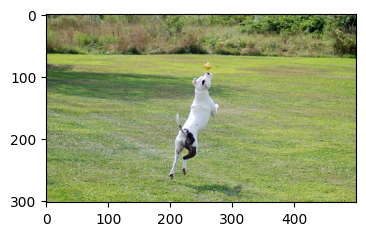

In [ ]:
# hiển thị thử 1 dữ liệu
n = 15
img = Image.open(image_path + df['image'][5*n])
plt.figure(figsize=(4, 4))
plt.imshow(img)
print(df['caption'][5*n:5*n+5])

In [ ]:
print(df['caption'][5*n:5*n+6])
#khi in cái này ra thì sẽ thấy 1 dòng caption khác

75    a black and white dog jumping in the air to ge...
76    A black and white dog jumps up towards a yello...
77             A dog leaps to catch a ball in a field .
78    A white dog is trying to catch a ball in midai...
79    The white dog is playing in a green field with...
80    A child and a woman are at waters edge in a bi...
Name: caption, dtype: object


** Preprocessing captions**

In [ ]:
import re
def caption_preprocessing(text, remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)
  # thay thế tất các ký tự không có nằm trong pattern trên, hay là loại bỏ
  # các ký tự không cần thiết như dấu câu bằng khoảng trắng.
  text=text.split()
  # chuyển thành chữ thường hết
  text = [word.lower() for word in text]
  # loại bỏ ký tự 's' và 'a'
  # text = [word for word in text if len(word)>1]

  # remove tokens with numbers in them
  text = [word for word in text if word.isalpha()]
  # store as string
  text =  ' '.join(text)

  # insert 'startseq', 'endseq' cho chuỗi
  text = 'startseq ' + text + ' endseq'
  return text

print(caption_preprocessing('chao .. ban $ hello980 78we it\'s a table.#'))


startseq chao ban its a table endseq


In [ ]:
# xử lý với các caption
df['caption'] = df['caption'].apply(caption_preprocessing)
df['caption']

0        startseq a child in a pink dress is climbing u...
1        startseq a girl going into a wooden building e...
2        startseq a little girl climbing into a wooden ...
3        startseq a little girl climbing the stairs to ...
4        startseq a little girl in a pink dress going i...
                               ...                        
40450    startseq a man in a pink shirt climbs a rock f...
40451    startseq a man is rock climbing high in the ai...
40452    startseq a person in a red shirt climbing up a...
40453        startseq a rock climber in a red shirt endseq
40454    startseq a rock climber practices on a rock cl...
Name: caption, Length: 40455, dtype: object

In [ ]:
# đếm số từ trong dataset và độ dài lớn nhất của caption
word_counts = {}
max_length = 0
for text in df['caption']:
  words = text.split()
  max_length = len(words) if (max_length < len(words)) else max_length
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1
print(len(word_counts))
print(max_length)

8777
37


In [ ]:
# Chỉ lấy các từ xuất hiện trên 15 lần xem thế nào
word_count_threshold = 15
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


preprocessed words 8777 -> 1556


In [ ]:
i2w = {}
w2i = {}

id = 1
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1

print(len(i2w), len(w2i))
print(i2w[300])
print(w2i["setting"])

# từ ra chỉ mục, và từ chỉ mục ra từ

1556 1556
them
295


**sử dụng Glove để embedding word**

In [ ]:

! wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-03-15 04:26:52--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-15 04:26:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2024-03-15 04:29:31 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
! mkdir glove
! unzip glove.6B.zip -d glove

Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


In [ ]:
glove_dir = '/content/glove/'
embeddings_index = {} # empty dictionary
file = open(glove_dir + 'glove.6B.200d.txt', encoding="utf-8")

for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['boy']

array([ 0.13328  , -0.063486 , -0.46471  , -0.51955  ,  0.079604 ,
       -0.1715   , -0.30575  ,  0.15448  ,  0.075202 , -0.44888  ,
        0.24231  ,  0.021223 ,  1.0471   ,  0.53607  ,  0.19587  ,
       -0.10826  , -0.40146  ,  0.031243 , -0.11277  ,  0.36173  ,
        0.71412  ,  2.1059   , -0.16003  ,  0.091236 , -0.26872  ,
       -0.60152  ,  0.19542  , -1.1688   , -0.32821  , -0.25996  ,
        0.056736 ,  0.1233   , -0.10844  ,  0.4492   ,  0.47993  ,
        0.039362 , -0.61086  ,  0.21564  , -0.56351  ,  0.016631 ,
       -0.65341  ,  0.32702  , -0.45518  ,  0.32215  , -0.387    ,
        0.21662  ,  0.76857  ,  0.41205  ,  0.12678  ,  0.59011  ,
        0.1943   , -0.07646  , -0.28204  , -0.45991  , -0.22153  ,
        0.012127 , -0.71267  ,  0.24982  , -0.038764 , -0.008747 ,
       -0.27897  , -0.73961  , -0.37944  ,  0.48481  , -0.21584  ,
       -0.77279  ,  0.32943  ,  0.21289  ,  0.46601  ,  0.16991  ,
        0.76738  , -0.30901  , -0.76706  ,  0.49542  , -0.6872

In [ ]:
# Sở dĩ nó bỏ phần từ đầu tiên vì trong bộ dữ liệu phần từ là từ được biểu diễn

In [ ]:
# từ boy có giá trị vecto như kia
embeddings_index['boy'].shape


(200,)

In [ ]:
# thiết lập biến cho học máy
# embedding_dim đại diện cho số chiều của vectơ biểu diễn cho mỗi từ trong mô hình
# cái giá trị embedding_dim em không biết người ta chọn kiểu gì.
embedding_dim = 200
vocab_size = len(vocab) + 1 # thêm 1 padding
vocab_size

1557

In [ ]:
# tạo vecto biểu diễn từ trong với chiều cao là số từ trong bộ từ vocab và
# chiều rộng là embedding_dim 200.
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in w2i.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(1557, 200)


In [ ]:
from pickle import dump, load

In [ ]:
!mkdir -p /content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/

In [ ]:
# Lưu ý không được viết các folder tên có khoảng trống

In [ ]:
with open("/content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/embedding_matrix.pkl", "wb") as file:
    dump(embedding_matrix, file)

In [ ]:
embedding_matrix = load(open("/content/gdrive/My Drive/ColabNotebooks/ImageCaptioning/embedding_matrix.pkl", "rb"))
embedding_matrix.shape

(1557, 200)

Sử dụng Inception V3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3()

96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.models import Model
# Tạo model mới, bỏ layer cuối từ inception v3
# layer cuối dùng để phân loại khá lớn nên tính toán mất nhiều thời gian mà không cần
model_new = Model(model.input, model.layers[-2].output)

In [ ]:

model_new.input_shape

(None, 299, 299, 3)

In [ ]:
model_new.summary()

In [ ]:
images = {}
captions = {}

start = time()
for i in range(len(df)):
   images[df['image'][i]] = np.array(Image.open(image_path + df['image'][i]))
   try:
    captions[df['image'][i]].append(df['caption'][i])
   except:
    captions[df['image'][i]] = [df['caption'][i]]

print(len(images), len(captions))
print('Time: ',time() - start)

8091 8091
Time:  226.02078437805176


In [ ]:
with open("/content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/encoded_captions.pkl", "wb") as file:
    dump(captions, file)

In [ ]:
captions = load(open("/content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/encoded_captions.pkl", "rb"))
len(captions)

8091

In [ ]:
images[df['image'][1]].shape

(500, 375, 3)

In [ ]:
images[df['image'][3]].shape

(500, 375, 3)

In [ ]:
tmp = np.array([[0,2,1],[3,5,6]])
tmp = np.expand_dims(tmp, axis=0)
tmp

array([[[0, 2, 1],
        [3, 5, 6]]])

In [ ]:
from keras.applications.inception_v3 import preprocess_input
# Image embedding thành vector (2048, )
def encode(image):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = np.resize(image, (299, 299, 3 ))
    # Add one more dimension
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = preprocess_input(img)

    feature_vec = model_new.predict(img) # Get the encoding vector for the image
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return feature_vec

In [ ]:
# Gọi hàm encode với các ảnh trong traning set
start = time()
encoding_image = {}
for id, img in images.items():
    encoding_image[id] = encode(img)

print("Time taken in seconds =", time()-start)

In [ ]:
encoding_image['2089542487_b4c1ee7025.jpg'].shape

(2048,)

In [ ]:
train_features = encoding_image

In [ ]:
from pickle import dump, load
with open("/content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/encoded_train_images.pkl", "wb") as file:
    dump(encoding_image, file)

In [ ]:
train_features = load(open("/content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/encoded_train_images.pkl", "rb"))
len(train_features)

8091

Training

In [ ]:
model = "a"

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(captions, images, w2i, max_length, batch_size):

  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for id, caps in captions.items():
      n += 1
      image = images[id]
      for cap in caps:
        # encode the sequence
        seq = [w2i[word] for word in cap.split(' ') if word in w2i]

        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]

          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          # store
          X_image.append(image)
          X_cap.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        yield ([np.array(X_image), np.array(X_cap)], np.array(y))
        X_image, X_cap, y = [], [], []
        n = 0

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Input
from tensorflow.keras import optimizers

In [ ]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


# max_length = 37, vocab_size = 1557, embedding_dim = 200
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

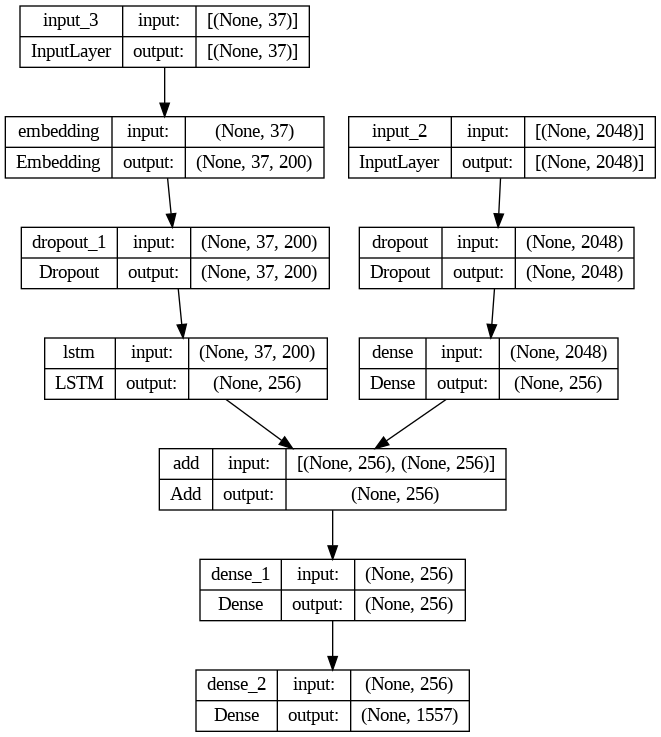

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 37)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 37, 200)              311400    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [ ]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 1
batch_size = 16
steps = len(train_features)

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/cp.ckpt"

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only=False, save_weights_only=True, verbose=1)

In [ ]:
generator = data_generator(captions=captions, images=train_features, w2i=w2i, max_length=max_length, batch_size=batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

8091/8091 [==============================] - ETA: 0s - loss: 3.5497
Epoch 1: saving model to /content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/cp.ckpt
8091/8091 [==============================] - 21824s 3s/step - loss: 3.5497


In [ ]:
import h5py

In [ ]:
!pip install pydrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
model.save_weights('/content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/model.h5')

In [ ]:
model.save('/content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


sử dụng mô hình

In [ ]:
from tensorflow.keras.models import load_model
model_new = load_model('/content/gdrive/MyDrive/ColabNotebooks/ImageCaptioning/model.h5')

In [ ]:

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_new.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

200    startseq two constructions workers sit on a be...
201    startseq two construction workers are sitting ...
202    startseq two construction workers sitting on a...
203    startseq two construction workers take a seat ...
204    startseq two men take a break from constructio...
Name: caption, dtype: object


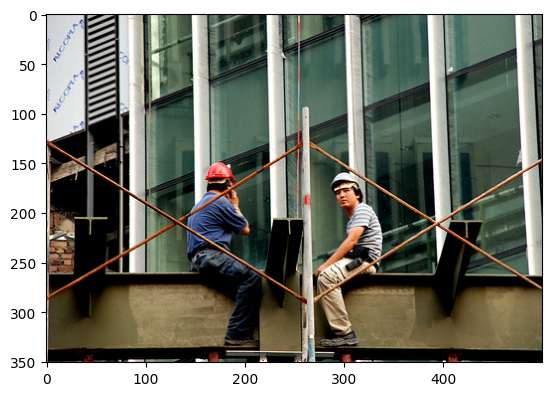

a man in a red shirt is standing on a bench


In [ ]:
pic = list(train_features.keys())[40]
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + pic)
print(df['caption'][df['image'] == pic])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print(predict)

In [ ]:
#Nguyễn Khánh Thọ Lộc